# Doing More with Data: `pandas`

# Contents:

1. Setup
2. Intro to `pandas`
2. Getting data
3. Profiling and initial data exploration: changing data types, descriptive statistics
4. Wrangling and plotting: concatenating, merging, adding and removing columns, filtering and selecting, null values, grouping and aggregating, plotting
5. Writing to file
6. More wrangling: reshaping, applying functions

## Data

This module uses four datasets: [bike thefts](https://open.toronto.ca/dataset/bicycle-thefts/), [TTC subway delays and subway delay reason codes](https://open.toronto.ca/dataset/ttc-subway-delay-data/), and [neighbourhood profiles](https://open.toronto.ca/dataset/neighbourhood-profiles/). All four are available in the course repo, and originally come from Toronto Open Data.

The specific file names are:
- bicycle-thefts - 4326.csv
- ttc-subway-delay-data-2021.xlsx
- ttc-subway-delay-codes.xlsx
- neighbourhood-profiles-2016-140-model.csv

# `pandas`

## What is `pandas`?

`pandas` is a package for data analysis and manipulation. (The name is a reference to panel data, not the animal.) It gives us data frames, which represent data in a table of columns and rows, and functions to manipulate and plot them. `pandas` also provides a slew of functions for reading and writing data to a variety of sources, including files, SQL databases, and compressed binary formats.

In [1]:
# If there are issues with library installation please type the following commands into Terminal:

# conda install pandas

In [2]:
import numpy as np
# pd is the conventional alias for pandas
import pandas as pd

# display all columns
pd.set_option("display.max_columns", None)

## DataFrames

Columns are labeled with their names. Rows also have a label, or _index_. If row labels are not specified, `pandas` uses numbers as the default. Each column is a _Series_, or one-dimensional array, where values share a data type. Unlike `numpy` arrays, DataFrames can have columns of different data types. However, like arrays and lists, **DataFrames are mutable** -- this means that if more than one variable refers to the same DataFrame, updating one updates them all!

## Getting data

We can create a DataFrame manually with `DataFrame()` constructor. If a dictionary is passed to `DataFrame()`, the keys become column names, and the values become the rows. Calling just `DataFrame()` creates an empty DataFrame to which data can be added later.

In [3]:
trees = pd.DataFrame({
    'name': ['sugar maple', 'black oak', 'white ash', 'douglas fir'],
    'avg_lifespan': [300, 100, 260, 450],
    'quantity': [53, 207, 178, 93]
})
trees

,name,avg_lifespan,quantity
0,sugar maple,300,53
1,black oak,100,207
2,white ash,260,178
3,douglas fir,450,93


We can create an individual column with `Series()`. The `name` argument corresponds to a column name.

In [4]:
tree_types = pd.Series(['deciduous', 'deciduous', 'deciduous', 'evergreen'],
                       name='foliage')
tree_types

0    deciduous
1    deciduous
2    deciduous
3    evergreen
Name: foliage, dtype: object

### Data from csv

Of course, we're more likely to load data into a DataFrame than to create DataFrames manually. `pandas` has read functions for different file formats. To read data from a csv or other delimited file, we use `pd.read_csv()`, then pass in the local file path or the URL of the csv to read. `pandas` will infer the data type of each column based on the values in the first chunk of the file loaded.

In [5]:
thefts = pd.read_csv('../data/bicycle-thefts - 4326.csv')

## Profiling and initial data cleaning

We got our data, but now we need to understand what's in it. We can start to understand the DataFrame by checking out its `dtypes` and `shape` attributes, which give column data types and row by column dimensions, respectively. Note that `object` is `pandas`' way of saying values are represented as string data.

In [6]:
thefts.shape

(25569, 33)

The `object` dtype in a pandas DataFrame represents columns that contain text or mixed types of data. When you use the `.dtypes` method on a pandas DataFrame and see that a column is listed as having the `object` dtype, it typically means that the data within that column is stored as strings (there isn't a dedicated `str` dtype for columns). However, `object` dtype columns can also hold data that is a mix of different types, including numbers, strings, or even more complex objects like lists or dictionaries, if the data within the column is not homogenous.

The `object` dtype is essentially a catch-all for columns that don't fit neatly into more specific types like `int64`, `float64`, `datetime64`, etc. 

In [7]:
thefts.dtypes

_id                        int64
OBJECTID                   int64
event_unique_id           object
Primary_Offence           object
Occurrence_Date           object
Occurrence_Year            int64
Occurrence_Month          object
Occurrence_DayOfWeek      object
Occurrence_DayOfMonth      int64
Occurrence_DayOfYear       int64
Occurrence_Hour            int64
Report_Date               object
Report_Year                int64
Report_Month              object
Report_DayOfWeek          object
Report_DayOfMonth          int64
Report_DayOfYear           int64
Report_Hour                int64
Division                  object
City                      object
Hood_ID                   object
NeighbourhoodName         object
Location_Type             object
Premises_Type             object
Bike_Make                 object
Bike_Model                object
Bike_Type                 object
Bike_Speed                 int64
Bike_Colour               object
Cost_of_Bike             float64
Status    

### `head()`s and `tail()`s

To check out the first few rows, we can call the DataFrame `head()` method. Similarly, we can see the last few rows with the `tail()` method. Five rows are shown by default, but we can change that by passing an integer as an argument.

In [8]:
thefts.head()

,_id,OBJECTID,event_unique_id,Primary_Offence,Occurrence_Date,Occurrence_Year,Occurrence_Month,Occurrence_DayOfWeek,Occurrence_DayOfMonth,Occurrence_DayOfYear,Occurrence_Hour,Report_Date,Report_Year,Report_Month,Report_DayOfWeek,Report_DayOfMonth,Report_DayOfYear,Report_Hour,Division,City,Hood_ID,NeighbourhoodName,Location_Type,Premises_Type,Bike_Make,Bike_Model,Bike_Type,Bike_Speed,Bike_Colour,Cost_of_Bike,Status,ObjectId2,geometry
0,1,17744,GO-20179016397,THEFT UNDER,2017-10-03T00:00:00,2017,October,Tuesday,3,276,14,2017-10-03T00:00:00,2017,October,Tuesday,3,276,18,D22,Toronto,15,Kingsway South (15),"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,GI,ESCAPE 2,OT,7,BLK,700.0,STOLEN,1,"{'type': 'Point', 'coordinates': (-79.50655965..."
1,2,17759,GO-20172033056,THEFT UNDER - BICYCLE,2017-11-08T00:00:00,2017,November,Wednesday,8,312,3,2017-11-08T00:00:00,2017,November,Wednesday,8,312,22,D22,Toronto,15,Kingsway South (15),"Single Home, House (Attach Garage, Cottage, Mo...",House,UNKNOWN MAKE,NaN,TO,1,BLK,1100.0,RECOVERED,2,"{'type': 'Point', 'coordinates': (-79.50484874..."
2,3,17906,GO-20189030822,THEFT UNDER - BICYCLE,2018-09-14T00:00:00,2018,September,Friday,14,257,9,2018-09-17T00:00:00,2018,September,Monday,17,260,16,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,OT,CROSSTRAIL,MT,24,BLK,904.0,STOLEN,3,"{'type': 'Point', 'coordinates': (-79.51170915..."
3,4,17962,GO-2015804467,THEFT UNDER,2015-05-07T00:00:00,2015,May,Thursday,7,127,18,2015-05-14T00:00:00,2015,May,Thursday,14,134,14,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,GT,NaN,TO,10,BLKDGR,400.0,STOLEN,4,"{'type': 'Point', 'coordinates': (-79.51170915..."
4,5,17963,GO-20159002781,THEFT UNDER,2015-05-16T00:00:00,2015,May,Saturday,16,136,12,2015-05-16T00:00:00,2015,May,Saturday,16,136,15,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,GI,NaN,MT,6,RED,600.0,STOLEN,5,"{'type': 'Point', 'coordinates': (-79.51132657..."


In [9]:
# last 3
thefts.tail(3)

,_id,OBJECTID,event_unique_id,Primary_Offence,Occurrence_Date,Occurrence_Year,Occurrence_Month,Occurrence_DayOfWeek,Occurrence_DayOfMonth,Occurrence_DayOfYear,Occurrence_Hour,Report_Date,Report_Year,Report_Month,Report_DayOfWeek,Report_DayOfMonth,Report_DayOfYear,Report_Hour,Division,City,Hood_ID,NeighbourhoodName,Location_Type,Premises_Type,Bike_Make,Bike_Model,Bike_Type,Bike_Speed,Bike_Colour,Cost_of_Bike,Status,ObjectId2,geometry
25566,25567,11462,GO-20169005434,THEFT UNDER,2016-06-04T00:00:00,2016,June,Saturday,4,156,22,2016-06-07T00:00:00,2016,June,Tuesday,7,159,16,D42,Toronto,132,Malvern (132),"Apartment (Rooming House, Condo)",Apartment,SC,ANTRIM,MT,24,WHI,700.0,STOLEN,25567,"{'type': 'Point', 'coordinates': (-79.2360175,..."
25567,25568,11695,GO-20161170896,THEFT UNDER,2016-07-04T00:00:00,2016,July,Monday,4,186,20,2016-07-04T00:00:00,2016,July,Monday,4,186,20,D42,Toronto,132,Malvern (132),Other Commercial / Corporate Places (For Profi...,Commercial,UNKNOWN MAKE,NaN,SC,1,NaN,3000.0,STOLEN,25568,"{'type': 'Point', 'coordinates': (-79.20060719..."
25568,25569,11883,GO-20169007653,THEFT UNDER - BICYCLE,2016-07-22T00:00:00,2016,July,Friday,22,204,9,2016-07-23T00:00:00,2016,July,Saturday,23,205,11,D42,Toronto,132,Malvern (132),"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,SU,ASCENT MOUNTAIN,MT,21,ONG,200.0,STOLEN,25569,"{'type': 'Point', 'coordinates': (-79.23734742..."


### Renaming columns

Most, but not all, of the bike theft columns follow the same naming convention. For convenience's sake, though, let's convert the column names to all lowercase. We can do this with the DataFrame `rename()` method. `rename()` accepts either a dictionary with current column names as the keys and new names as the values, or the name of a function to transform names. Let's write a function.

In [10]:
# notice that we do not add () to the function name
thefts = thefts.rename(columns=str.lower)

In [11]:
thefts

,_id,objectid,event_unique_id,primary_offence,occurrence_date,occurrence_year,occurrence_month,occurrence_dayofweek,occurrence_dayofmonth,occurrence_dayofyear,occurrence_hour,report_date,report_year,report_month,report_dayofweek,report_dayofmonth,report_dayofyear,report_hour,division,city,hood_id,neighbourhoodname,location_type,premises_type,bike_make,bike_model,bike_type,bike_speed,bike_colour,cost_of_bike,status,objectid2,geometry
0,1,17744,GO-20179016397,THEFT UNDER,2017-10-03T00:00:00,2017,October,Tuesday,3,276,14,2017-10-03T00:00:00,2017,October,Tuesday,3,276,18,D22,Toronto,15,Kingsway South (15),"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,GI,ESCAPE 2,OT,7,BLK,700.0,STOLEN,1,"{'type': 'Point', 'coordinates': (-79.50655965..."
1,2,17759,GO-20172033056,THEFT UNDER - BICYCLE,2017-11-08T00:00:00,2017,November,Wednesday,8,312,3,2017-11-08T00:00:00,2017,November,Wednesday,8,312,22,D22,Toronto,15,Kingsway South (15),"Single Home, House (Attach Garage, Cottage, Mo...",House,UNKNOWN MAKE,NaN,TO,1,BLK,1100.0,RECOVERED,2,"{'type': 'Point', 'coordinates': (-79.50484874..."
2,3,17906,GO-20189030822,THEFT UNDER - BICYCLE,2018-09-14T00:00:00,2018,September,Friday,14,257,9,2018-09-17T00:00:00,2018,September,Monday,17,260,16,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,OT,CROSSTRAIL,MT,24,BLK,904.0,STOLEN,3,"{'type': 'Point', 'coordinates': (-79.51170915..."
3,4,17962,GO-2015804467,THEFT UNDER,2015-05-07T00:00:00,2015,May,Thursday,7,127,18,2015-05-14T00:00:00,2015,May,Thursday,14,134,14,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,GT,NaN,TO,10,BLKDGR,400.0,STOLEN,4,"{'type': 'Point', 'coordinates': (-79.51170915..."
4,5,17963,GO-20159002781,THEFT UNDER,2015-05-16T00:00:00,2015,May,Saturday,16,136,12,2015-05-16T00:00:00,2015,May,Saturday,16,136,15,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,GI,NaN,MT,6,RED,600.0,STOLEN,5,"{'type': 'Point', 'coordinates': (-79.51132657..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25564,25565,9361,GO-2015543181,MISCHIEF UNDER,2015-04-01T00:00:00,2015,April,Wednesday,1,91,17,2015-04-01T00:00:00,2015,April,Wednesday,1,91,19,D42,Toronto,132,Malvern (132),"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,UNKNOWN MAKE,BMX WILD MAN,RG,0,SIL,600.0,STOLEN,25565,"{'type': 'Point', 'coordinates': (-79.21555349..."
25565,25566,11318,GO-20169004589,THEFT UNDER,2016-05-16T00:00:00,2016,May,Monday,16,137,21,2016-05-16T00:00:00,2016,May,Monday,16,137,21,D42,Toronto,132,Malvern (132),"Single Home, House (Attach Garage, Cottage, Mo...",House,SC,NaN,OT,14,NaN,900.0,STOLEN,25566,"{'type': 'Point', 'coordinates': (-79.21767046..."
25566,25567,11462,GO-20169005434,THEFT UNDER,2016-06-04T00:00:00,2016,June,Saturday,4,156,22,2016-06-07T00:00:00,2016,June,Tuesday,7,159,16,D42,Toronto,132,Malvern (132),"Apartment (Rooming House, Condo)",Apartment,SC,ANTRIM,MT,24,WHI,700.0,STOLEN,25567,"{'type': 'Point', 'coordinates': (-79.2360175,..."
25567,25568,11695,GO-20161170896,THEFT UNDER,2016-07-04T00:00:00,2016,July,Monday,4,186,20,2016-07-04T00:00:00,2016,July,Monday,4,186,20,D42,Toronto,132,Malvern (132),Other Commercial / Corporate Places (For Profi...,Commercial,UNKNOWN MAKE,NaN,SC,1,NaN,3000.0,STOLEN,25568,"{'type': 'Point', 'coordinates': (-79.20060719..."


Let's also rename `cost_of_bike` so it follows the pattern of the other bike attribute columns.

In [12]:
thefts = thefts.rename(columns={'cost_of_bike':'bike_cost'})

# view column names
# when you wrap a DataFrame object with the list() function, Python converts the DataFrame's column headers into a list
print(list(thefts))

['_id', 'objectid', 'event_unique_id', 'primary_offence', 'occurrence_date', 'occurrence_year', 'occurrence_month', 'occurrence_dayofweek', 'occurrence_dayofmonth', 'occurrence_dayofyear', 'occurrence_hour', 'report_date', 'report_year', 'report_month', 'report_dayofweek', 'report_dayofmonth', 'report_dayofyear', 'report_hour', 'division', 'city', 'hood_id', 'neighbourhoodname', 'location_type', 'premises_type', 'bike_make', 'bike_model', 'bike_type', 'bike_speed', 'bike_colour', 'bike_cost', 'status', 'objectid2', 'geometry']


### Profiling columns

It can be useful to focus on a subset of columns, particularly to understand value sets. To select a single column in a DataFrame, we can supply the name of the column in square brackets, just like we did when accessing values in a dictionary. `pandas` will return the column as a Series. To get unique values, we can use the `unique()` Series method. If we want to count how many times each value appears, we can use the `value_counts()` method.

In [13]:
thefts['status']

0           STOLEN
1        RECOVERED
2           STOLEN
3           STOLEN
4           STOLEN
           ...    
25564       STOLEN
25565       STOLEN
25566       STOLEN
25567       STOLEN
25568       STOLEN
Name: status, Length: 25569, dtype: object

In [14]:
thefts['status'].unique()

array(['STOLEN', 'RECOVERED', 'UNKNOWN'], dtype=object)

In [15]:
thefts['status'].value_counts()

status
STOLEN       24807
UNKNOWN        454
RECOVERED      308
Name: count, dtype: int64

We can summarize numeric Series much like we did with `numpy` functions.

In [16]:
thefts['bike_cost'].median()

600.0

In [17]:
thefts['bike_cost'].quantile(0.9) #qth quantile

2000.0

### `info()`

We can get an overview of the DataFrame by profiling it with the `info()` method.

`info()` prints a lot of information about a DataFrame, including:
* the `shape` as the number of rows and columns
* column names and their `dtype`
* the number of non-null values in each column
* how big the DataFrame is in terms of memory usage

The bicycle theft data looks quite complete, though some records are missing bike descriptors like bike_make, bike_model, bike_colour, and bike_cost.

Most of the column dtypes make sense. We'll want to convert the dates to proper dates. We may also want to convert string columns with limited value sets, like status, to categorical data.

In [18]:
thefts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25569 entries, 0 to 25568
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id                    25569 non-null  int64  
 1   objectid               25569 non-null  int64  
 2   event_unique_id        25569 non-null  object 
 3   primary_offence        25569 non-null  object 
 4   occurrence_date        25569 non-null  object 
 5   occurrence_year        25569 non-null  int64  
 6   occurrence_month       25569 non-null  object 
 7   occurrence_dayofweek   25569 non-null  object 
 8   occurrence_dayofmonth  25569 non-null  int64  
 9   occurrence_dayofyear   25569 non-null  int64  
 10  occurrence_hour        25569 non-null  int64  
 11  report_date            25569 non-null  object 
 12  report_year            25569 non-null  int64  
 13  report_month           25569 non-null  object 
 14  report_dayofweek       25569 non-null  object 
 15  re

### Changing data types

Before exploring the bike theft data further, let's fix the date and categorical columns. To convert a column to datetime, we use the `pd.to_datetime()` function, passing in the column to convert, and reassign the output back to the column we're converting.

`pandas` knows how to convert the dates in the bike thefts data, but for less common formats, it is necessary to use the `format` keyword argument to specify how dates should be parsed. `format` strings use `strftime` codes. See https://strftime.org/ for a cheat sheet.

In [19]:
thefts['occurrence_date'] = pd.to_datetime(thefts['occurrence_date'])
thefts['occurrence_date']

0       2017-10-03
1       2017-11-08
2       2018-09-14
3       2015-05-07
4       2015-05-16
           ...    
25564   2015-04-01
25565   2016-05-16
25566   2016-06-04
25567   2016-07-04
25568   2016-07-22
Name: occurrence_date, Length: 25569, dtype: datetime64[ns]

In [20]:
# convert report_date without the format argument
thefts['report_date'] = pd.to_datetime(thefts['report_date'])
thefts['report_date']

0       2017-10-03
1       2017-11-08
2       2018-09-17
3       2015-05-14
4       2015-05-16
           ...    
25564   2015-04-01
25565   2016-05-16
25566   2016-06-07
25567   2016-07-04
25568   2016-07-23
Name: report_date, Length: 25569, dtype: datetime64[ns]

All other data type conversions can be done with the `astype()` method. If we were converting to a number, `pd.to_numeric()` provides an easy way to convert without having to pick a specific numeric data type.

In [21]:
# 'category' data type represents a variable that can take on a limited, fixed number of possible values
# useful for representing data that can be separated into distinct groups based on certain characteristics
# but doesn't necessarily have a mathematical order or numerical relationship between them

thefts['status'] = thefts['status'].astype('category')
thefts['status']

0           STOLEN
1        RECOVERED
2           STOLEN
3           STOLEN
4           STOLEN
           ...    
25564       STOLEN
25565       STOLEN
25566       STOLEN
25567       STOLEN
25568       STOLEN
Name: status, Length: 25569, dtype: category
Categories (3, object): ['RECOVERED', 'STOLEN', 'UNKNOWN']

We can select and convert multiple columns at once by passing a list of columns in the square brackets., then using `.astype()`.

In [22]:
thefts[['location_type', 'premises_type']] = thefts[['location_type','premises_type']].astype('category')

# check data types
thefts[['location_type', 'premises_type']].dtypes

location_type    category
premises_type    category
dtype: object

### `describe()`

To get a sense of the values in a DataFrame, we can use the `describe()` method. `describe()` summarizes only numeric columns by default. Passing the `include='all'` argument will produce summary statistics for other columns as well.

In [23]:
thefts.describe(include='all') 

,_id,objectid,event_unique_id,primary_offence,occurrence_date,occurrence_year,occurrence_month,occurrence_dayofweek,occurrence_dayofmonth,occurrence_dayofyear,occurrence_hour,report_date,report_year,report_month,report_dayofweek,report_dayofmonth,report_dayofyear,report_hour,division,city,hood_id,neighbourhoodname,location_type,premises_type,bike_make,bike_model,bike_type,bike_speed,bike_colour,bike_cost,status,objectid2,geometry
count,25569.000000,25569.000000,25569,25569,25569,25569.000000,25569,25569,25569.000000,25569.000000,25569.000000,25569,25569.000000,25569,25569,25569.000000,25569.000000,25569.000000,25569,25569,25569,25569,25569,25569,25448,15923,25569,25569.000000,23508,23825.000000,25569,25569.000000,25569
unique,NaN,NaN,22771,66,NaN,NaN,12,7,NaN,NaN,NaN,NaN,NaN,12,7,NaN,NaN,NaN,18,2,141,141,42,7,820,8097,13,NaN,252,NaN,3,NaN,5816
top,NaN,NaN,GO-20201550944,THEFT UNDER,NaN,NaN,July,Friday,NaN,NaN,NaN,NaN,NaN,July,Monday,NaN,NaN,NaN,D14,Toronto,77,Waterfront Communities-The Island (77),"Apartment (Rooming House, Condo)",Outside,OT,UNKNOWN,MT,NaN,BLK,NaN,STOLEN,NaN,"{'type': 'Point', 'coordinates': (-79.38372586..."
freq,NaN,NaN,14,11904,NaN,NaN,4002,3924,NaN,NaN,NaN,NaN,NaN,3988,4318,NaN,NaN,NaN,4580,25560,2576,2576,5887,7960,4991,304,8245,NaN,7422,NaN,24807,NaN,167
mean,12785.000000,12909.173218,NaN,NaN,2017-09-04 03:39:28.321013504,2017.124174,NaN,NaN,15.616684,202.227698,13.274395,2017-09-12 12:02:37.127771904,2017.143572,NaN,NaN,15.924870,203.493723,14.224139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.164144,NaN,949.542371,NaN,12785.000000,NaN
min,1.000000,1.000000,NaN,NaN,2009-09-01 00:00:00,2009.000000,NaN,NaN,1.000000,1.000000,0.000000,2014-01-01 00:00:00,2014.000000,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000,NaN
25%,6393.000000,6456.000000,NaN,NaN,2016-01-06 00:00:00,2016.000000,NaN,NaN,8.000000,153.000000,9.000000,2016-01-22 00:00:00,2016.000000,NaN,NaN,9.000000,154.000000,11.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,350.000000,NaN,6393.000000,NaN
50%,12785.000000,12918.000000,NaN,NaN,2017-09-05 00:00:00,2017.000000,NaN,NaN,16.000000,205.000000,14.000000,2017-09-12 00:00:00,2017.000000,NaN,NaN,16.000000,206.000000,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,600.000000,NaN,12785.000000,NaN
75%,19177.000000,19360.000000,NaN,NaN,2019-06-20 00:00:00,2019.000000,NaN,NaN,23.000000,259.000000,19.000000,2019-06-26 00:00:00,2019.000000,NaN,NaN,23.000000,260.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.000000,NaN,1000.000000,NaN,19177.000000,NaN
max,25569.000000,25806.000000,NaN,NaN,2020-12-30 00:00:00,2020.000000,NaN,NaN,31.000000,366.000000,23.000000,2020-12-31 00:00:00,2020.000000,NaN,NaN,31.000000,366.000000,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.000000,NaN,120000.000000,NaN,25569.000000,NaN


## Wrangling and Plotting

### Combining datasets: concatenation

Just as `pandas` has `read_csv()` for flat files, there is a `read_excel()` function to load Excel files.

The TTC publishes subway delay data as a multi-sheet Excel workbook, with a month's worth of data per sheet. `read_excel()` loads just the first sheet in an Excel file by default. To load all sheets, pass in the keyword argument `sheet_name=None`. The result is a dictionary, where each key is the sheet name and each value is a DataFrame with the contents of the sheet.

In [24]:
# If there are issues with library installation please type the following commands into Terminal:
# conda install openpyxl

In [25]:
delays = pd.read_excel('../data/ttc-subway-delay-data-2021.xlsx', sheet_name=None)

In [26]:
type(delays)

dict

To combine them all, we create an empty DataFrame, then loop through the dictionary items and use `pd.concat()` to append data. `concat()` takes a list of DataFrames to combine. Since we did not specify an index, row labels are numbers: the first row of each sheet has an index of 0, and so on. To reset row labels so that they are sequential again, we set `ignore_index=True`.

In [27]:
# create an empty DataFrame
all_delays = pd.DataFrame()

for sheet_name, values in delays.items():
    # print the number of rows
    print(f'Adding {values.shape[0]} rows from {sheet_name}')
    # add each sheet to all_delays
    all_delays = pd.concat([all_delays, values],
                           axis=0,  # concatenate rows
                           ignore_index=True)  # reset row labels

all_delays.shape

Adding 1216 rows from January21
Adding 1245 rows from Feb 21
Adding 1167 rows from March '21
Adding 1170 rows from April '21
Adding 1168 rows from May '21
Adding 1265 rows from June 21
Adding 1244 rows from July 21
Adding 1273 rows from August 21
Adding 1433 rows from Sept 21
Adding 1560 rows from Oct 21
Adding 1771 rows from Nov 21
Adding 1858 rows from December21


(16370, 10)

In [28]:
all_delays.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2021-01-01,00:33,Friday,BLOOR STATION,MUPAA,0,0,N,YU,6046
1,2021-01-01,00:39,Friday,SHERBOURNE STATION,EUCO,5,9,E,BD,5250
2,2021-01-01,01:07,Friday,KENNEDY BD STATION,EUCD,5,9,E,BD,5249
3,2021-01-01,01:41,Friday,ST CLAIR STATION,MUIS,0,0,NaN,YU,0
4,2021-01-01,02:04,Friday,SHEPPARD WEST STATION,MUIS,0,0,NaN,YU,0


The TTC delays data includes a reason code for the delay. Code definitions, however, are in a separate Excel file, `ttc-subway-delay-codes.xlsx`. This file has been modified slightly to make it easier to work with. Codes are split between two tabs, so we will load both to a DataFrame, `delay_reasons`.

In [29]:
dr = pd.read_excel('../data/ttc-subway-delay-codes.xlsx', sheet_name=None)

delay_reasons = pd.DataFrame()
for sheet_name, values in dr.items():
    delay_reasons = pd.concat([delay_reasons, values],
                             axis=0,
                             ignore_index=True)

delay_reasons

,RMENU CODE,CODE DESCRIPTION,SUB OR SRT
0,EUAC,Air Conditioning,SUB
1,EUAL,Alternating Current,SUB
2,EUATC,ATC RC&S Equipment,SUB
3,EUBK,Brakes,SUB
4,EUBO,Body,SUB
...,...,...,...
195,TRNOA,No Operator Immediately Available,SRT
196,TRO,Transportation Department - Other,SRT
197,TRSET,Train Controls Improperly Shut Down,SRT
198,TRST,Storm Trains,SRT


We will rename the columns in both `all_delays` and `delay_reasons` so that we replace spaces with underscores as well as convert all letters to lowercase.

In [30]:
def clean_names(string):
    return string.lower().replace(' ', '_')

print(list(delay_reasons))
print(list(all_delays))
delay_reasons = delay_reasons.rename(columns=clean_names)
all_delays = all_delays.rename(columns=clean_names)
print(list(delay_reasons))
print(list(all_delays))

['RMENU CODE', 'CODE DESCRIPTION', 'SUB OR SRT']
['Date', 'Time', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Bound', 'Line', 'Vehicle']
['rmenu_code', 'code_description', 'sub_or_srt']
['date', 'time', 'day', 'station', 'code', 'min_delay', 'min_gap', 'bound', 'line', 'vehicle']


## Combining datasets: merging

Ideally, the delays data would include code descriptions. We can get descriptions into `all_delays` by _merging_ in `delay_reasons`. Merging is analagous to joining in SQL databases. To merge two DataFrames, we pass them as arguments to the `pd.merge()`. Then, we specify `how` to merge the two DataFrames and what column names to merge `on`.

Let's review the `all_delays` and `delay_reasons` DataFrames. `code` is equivalent to `rmenu_code`. If we pass in `all_delays` as the first DataFrame, then it will be the left frame, and `delay_reasons` the right one. We want to keep all the delay records, even if there isn't a matching code in `delay_reasons`, so we will perform a left join.

In [31]:
all_delays.head(2)

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle
0,2021-01-01,00:33,Friday,BLOOR STATION,MUPAA,0,0,N,YU,6046
1,2021-01-01,00:39,Friday,SHERBOURNE STATION,EUCO,5,9,E,BD,5250


In [32]:
delay_reasons.head(2)

,rmenu_code,code_description,sub_or_srt
0,EUAC,Air Conditioning,SUB
1,EUAL,Alternating Current,SUB


In [33]:
delays_w_reasons = pd.merge(all_delays,
                            delay_reasons,
                            how='left',
                            left_on='code',
                            right_on='rmenu_code')
delays_w_reasons.head(3)

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,rmenu_code,code_description,sub_or_srt
0,2021-01-01,00:33,Friday,BLOOR STATION,MUPAA,0,0,N,YU,6046,MUPAA,Passenger Assistance Alarm Activated - No Trou...,SUB
1,2021-01-01,00:39,Friday,SHERBOURNE STATION,EUCO,5,9,E,BD,5250,EUCO,Couplers,SUB
2,2021-01-01,01:07,Friday,KENNEDY BD STATION,EUCD,5,9,E,BD,5249,EUCD,Consequential Delay (2nd Delay Same Fault),SUB


## `drop()`

The resulting DataFrame has both our join columns, which is redundant. We can drop one with the `drop()` DataFrame method, passing in the column name(s) we want to drop in the `columns` keyword argument.

In [34]:
delays_w_reasons = delays_w_reasons.drop(columns='rmenu_code')
delays_w_reasons.head(3)

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,code_description,sub_or_srt
0,2021-01-01,00:33,Friday,BLOOR STATION,MUPAA,0,0,N,YU,6046,Passenger Assistance Alarm Activated - No Trou...,SUB
1,2021-01-01,00:39,Friday,SHERBOURNE STATION,EUCO,5,9,E,BD,5250,Couplers,SUB
2,2021-01-01,01:07,Friday,KENNEDY BD STATION,EUCD,5,9,E,BD,5249,Consequential Delay (2nd Delay Same Fault),SUB


## Creating new columns

Adding a column to a DataFrame looks like adding a key-value pair to a dictionary. At its simplest, we can assign a single value to repeat down a column.

In [35]:
delays_w_reasons['year'] = 2021
delays_w_reasons['year'].unique()

array([2021])

In [36]:
delays_w_reasons

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,code_description,sub_or_srt,year
0,2021-01-01,00:33,Friday,BLOOR STATION,MUPAA,0,0,N,YU,6046,Passenger Assistance Alarm Activated - No Trou...,SUB,2021
1,2021-01-01,00:39,Friday,SHERBOURNE STATION,EUCO,5,9,E,BD,5250,Couplers,SUB,2021
2,2021-01-01,01:07,Friday,KENNEDY BD STATION,EUCD,5,9,E,BD,5249,Consequential Delay (2nd Delay Same Fault),SUB,2021
3,2021-01-01,01:41,Friday,ST CLAIR STATION,MUIS,0,0,NaN,YU,0,Injured or ill Customer (In Station) - Transpo...,SUB,2021
4,2021-01-01,02:04,Friday,SHEPPARD WEST STATION,MUIS,0,0,NaN,YU,0,Injured or ill Customer (In Station) - Transpo...,SUB,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16365,2021-12-31,01:10,Friday,MUSEUM STATION,SUUT,0,0,N,YU,5591,Unauthorized at Track Level,SUB,2021
16366,2021-12-31,01:12,Friday,FINCH STATION,SUDP,5,10,S,YU,5983,Disorderly Patron,SUB,2021
16367,2021-12-31,01:21,Friday,EGLINTON WEST STATION,PUOPO,3,8,N,YU,6046,OPTO (COMMS) Train Door Monitoring,SUB,2021
16368,2021-12-31,01:37,Friday,SHEPPARD WEST STATION,SUDP,0,0,S,YU,5536,Disorderly Patron,SUB,2021


We can also write an expression and store the resulting values in a new column.

In [37]:
delays_w_reasons['hour_delay'] = round(delays_w_reasons['min_delay'] / 60, 2)
delays_w_reasons[['min_delay', 'hour_delay']].head()

,min_delay,hour_delay
0,0,0.00
1,5,0.08
2,5,0.08
3,0,0.00
4,0,0.00


It is also possible to extract parts of a datetime column with the `dt` accessor.

In [38]:
delays_w_reasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16370 entries, 0 to 16369
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              16370 non-null  datetime64[ns]
 1   time              16370 non-null  object        
 2   day               16370 non-null  object        
 3   station           16370 non-null  object        
 4   code              16370 non-null  object        
 5   min_delay         16370 non-null  int64         
 6   min_gap           16370 non-null  int64         
 7   bound             12119 non-null  object        
 8   line              16318 non-null  object        
 9   vehicle           16370 non-null  int64         
 10  code_description  16048 non-null  object        
 11  sub_or_srt        16048 non-null  object        
 12  year              16370 non-null  int64         
 13  hour_delay        16370 non-null  float64       
dtypes: datetime64[ns](1), 

In [39]:
delays_w_reasons['month'] = delays_w_reasons['date'].dt.month
delays_w_reasons['month']

0         1
1         1
2         1
3         1
4         1
         ..
16365    12
16366    12
16367    12
16368    12
16369    12
Name: month, Length: 16370, dtype: int32

It is possible to create a new integer column, `hour`, that contains the hour in which a delay occurred. Below we highlight two methods.

In [40]:
# two ways to extract hour
# convert to time, then access hour
delays_w_reasons['hour'] = pd.to_datetime(delays_w_reasons['time'], format='%H:%M').dt.hour

# split and take first part
delays_w_reasons['hour'] = delays_w_reasons['time'].str.split(':', expand=True)[0] #expandbool expands the split strings into separate columns
delays_w_reasons['hour'] = delays_w_reasons['hour'].astype(int)

## Filtering and selecting data

Let's take another look at the TTC subway delay data. There are only 4 subway lines in Toronto, but `describe()` reported 17 unique values.

In [41]:
delays_w_reasons['line'].unique()

array(['YU', 'BD', 'SHP', 'SRT', 'YU/BD', nan, 'YONGE/UNIVERSITY/BLOOR',
       'YU / BD', 'YUS', '999', 'SHEP', '36 FINCH WEST', 'YUS & BD',
       'YU & BD LINES', '35 JANE', '52', '41 KEELE', 'YUS/BD'],
      dtype=object)

Looks like some of the line values should be updated (YU/BD variants) and others should be dropped (e.g., 36 FINCH WEST, NaNs). Luckily there don't seem to be too many affected records, though the NaNs are not shown.

In [42]:
delays_w_reasons['line'].value_counts()

line
YU                        8880
BD                        5734
SHP                        657
SRT                        656
YU/BD                      346
YUS                         18
YU / BD                     17
YU & BD LINES                1
41 KEELE                     1
52                           1
35 JANE                      1
999                          1
YUS & BD                     1
36 FINCH WEST                1
SHEP                         1
YONGE/UNIVERSITY/BLOOR       1
YUS/BD                       1
Name: count, dtype: int64

### `.loc[]` and `isna()`

To find the records with no line, we can use `.loc[]`, which lets us access rows and columns with either a boolean array or row/column labels.

In this case, the boolean array is the product of the `isna()` Series method.

In [43]:
# access rows of data where line is NA
delays_w_reasons.loc[delays_w_reasons['line'].isna()]

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,code_description,sub_or_srt,year,hour_delay,month,hour
495,2021-01-13,15:22,Wednesday,FINCH WEST STATION,MUSAN,3,6,S,NaN,5751,Unsanitary Vehicle,SUB,2021,0.05,1,15
513,2021-01-13,22:08,Wednesday,EGLINTON WEST STATION,PUMEL,0,0,NaN,NaN,0,Escalator/Elevator Incident,SUB,2021,0.00,1,22
1044,2021-01-27,22:00,Wednesday,YONGE-UNIVERSITY AND B,MUO,0,0,NaN,NaN,0,Miscellaneous Other,SUB,2021,0.00,1,22
1045,2021-01-27,23:00,Wednesday,FINCH STATION,MUO,0,0,NaN,NaN,0,Miscellaneous Other,SUB,2021,0.00,1,23
1362,2021-02-04,01:45,Thursday,LAWRENCE STATION,TUSC,0,0,S,NaN,5596,Operator Overspeeding,SUB,2021,0.00,2,1
1679,2021-02-11,01:12,Thursday,GREENWOOD CARHOUSE,MUIE,0,0,NaN,NaN,0,Injured Employee,SUB,2021,0.00,2,1
2179,2021-02-22,08:27,Monday,BICHMOUNT DIVISION,MUIE,0,0,NaN,NaN,0,Injured Employee,SUB,2021,0.00,2,8
2204,2021-02-22,22:33,Monday,BLOOR STATION,SUAP,4,9,N,NaN,6006,Assault / Patron Involved,SUB,2021,0.07,2,22
2206,2021-02-22,23:36,Monday,EGLINTON STATION,MUO,0,0,NaN,NaN,0,Miscellaneous Other,SUB,2021,0.00,2,23
3039,2021-03-17,05:15,Wednesday,INGLIS BUILDING,PUMEL,0,0,NaN,NaN,0,Escalator/Elevator Incident,SUB,2021,0.00,3,5


`.loc[]` also lets us access data by label, with row conditions first and column conditions second.

In [44]:
(delays_w_reasons.loc[delays_w_reasons['line'].isna(),  # filter rows
                     ['time', 'station', 'line']]  # get columns
                 .head())  # first 5 lines to save space

,time,station,line
495,15:22,FINCH WEST STATION,NaN
513,22:08,EGLINTON WEST STATION,NaN
1044,22:00,YONGE-UNIVERSITY AND B,NaN
1045,23:00,FINCH STATION,NaN
1362,01:45,LAWRENCE STATION,NaN


### `query()`

Alternatively, we can use the DataFrame `query()` method, which takes a filter condition as a string, and returns a DataFrame of records that met the condition. `query()` is slower than `loc[]`, but it can be easier to read.

In [45]:
delays_w_reasons['line'].unique()

array(['YU', 'BD', 'SHP', 'SRT', 'YU/BD', nan, 'YONGE/UNIVERSITY/BLOOR',
       'YU / BD', 'YUS', '999', 'SHEP', '36 FINCH WEST', 'YUS & BD',
       'YU & BD LINES', '35 JANE', '52', '41 KEELE', 'YUS/BD'],
      dtype=object)

In [46]:
delays_w_reasons['line'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
16365    False
16366    False
16367    False
16368    False
16369    False
Name: line, Length: 16370, dtype: bool

In [47]:
# slower than .loc, but can be easier to read
delays_w_reasons.query('line.isna()').head()

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,code_description,sub_or_srt,year,hour_delay,month,hour
495,2021-01-13,15:22,Wednesday,FINCH WEST STATION,MUSAN,3,6,S,NaN,5751,Unsanitary Vehicle,SUB,2021,0.05,1,15
513,2021-01-13,22:08,Wednesday,EGLINTON WEST STATION,PUMEL,0,0,NaN,NaN,0,Escalator/Elevator Incident,SUB,2021,0.00,1,22
1044,2021-01-27,22:00,Wednesday,YONGE-UNIVERSITY AND B,MUO,0,0,NaN,NaN,0,Miscellaneous Other,SUB,2021,0.00,1,22
1045,2021-01-27,23:00,Wednesday,FINCH STATION,MUO,0,0,NaN,NaN,0,Miscellaneous Other,SUB,2021,0.00,1,23
1362,2021-02-04,01:45,Thursday,LAWRENCE STATION,TUSC,0,0,S,NaN,5596,Operator Overspeeding,SUB,2021,0.00,2,1


### `dropna()`

In this case, the number of records without lines is relatively small. Most do not have delay durations. Some appear to be at rail yards, i.e. not on a rail line. For our analysis, we may drop them with the `dropna()` DataFrame method. We can drop rows missing lines by passing a `subset`.

In [48]:
delays_w_reasons = delays_w_reasons.dropna(subset=['line'])

### Filtering data with `.loc[]` and `isin()`

We can use `.loc[]` to create a delays DataFrame without the invalid lines. To to this, we first create a list of values to exclude, then pass the list to the Series `isin()` method. Finally, we negate the expression, and assign the output back to `delays_w_reasons`.

**Note: The negation operator here is `~`, not `!`. The `and` and `or` operators are different as well: `&` and `|` respectively.**

In [49]:
# set up filter list
filter_list = ['999', '36 FINCH WEST', '35 JANE', '52', '41 KEELE']

In [50]:
# filter out records with invalid lines
delays_w_reasons = delays_w_reasons.loc[~delays_w_reasons['line'].isin(filter_list)]
delays_w_reasons['line'].unique()

array(['YU', 'BD', 'SHP', 'SRT', 'YU/BD', 'YONGE/UNIVERSITY/BLOOR',
       'YU / BD', 'YUS', 'SHEP', 'YUS & BD', 'YU & BD LINES', 'YUS/BD'],
      dtype=object)

### Replacing values with `str.replace()`

To standardize the YU/BD values, we can replace the less common ones. One way to do this is by selecting the line Series and using `str.replace()`, like below for "YUS".

In [51]:
delays_w_reasons['line'] = (delays_w_reasons['line']
                            .str.replace('YUS', 'YU'))
delays_w_reasons['line'].unique()

array(['YU', 'BD', 'SHP', 'SRT', 'YU/BD', 'YONGE/UNIVERSITY/BLOOR',
       'YU / BD', 'SHEP', 'YU & BD', 'YU & BD LINES'], dtype=object)

Another is to assign "YU/BD" to values selected by `.loc[]`

In [52]:
yubd_list = ['YONGE/UNIVERSITY/BLOOR',
             'YU / BD',
             'YU & BD',
             'YU & BD LINES']

# check the .loc[] selection
delays_w_reasons.loc[delays_w_reasons['line'].isin(yubd_list), 'line']

590      YONGE/UNIVERSITY/BLOOR
852                     YU / BD
1137                    YU / BD
1628                    YU / BD
1672                    YU / BD
1700                    YU / BD
6725                    YU / BD
7469                    YU / BD
8034                    YU & BD
8301                    YU / BD
8341                    YU / BD
8463                    YU / BD
9164                    YU / BD
9541              YU & BD LINES
9839                    YU / BD
10792                   YU / BD
11119                   YU / BD
11299                   YU / BD
12128                   YU / BD
15574                   YU / BD
Name: line, dtype: object

In [53]:
delays_w_reasons.loc[delays_w_reasons['line'].isin(yubd_list), 'line'] = 'YU/BD'
delays_w_reasons['line'].unique()

array(['YU', 'BD', 'SHP', 'SRT', 'YU/BD', 'SHEP'], dtype=object)

## Grouping

A core workflow in `pandas` is _split-apply-combine_:
* **splitting** data into groups
* **applying** a function to each group, such as calculating group sums, standardizing data, or filtering out some groups
* **combining** the results into a data structure

This workflow starts by grouping data by calling the `groupby()` method. We'll pass in a column name or list of names to group by.

In [54]:
line_groups = delays_w_reasons.groupby('line')

`groupby()` returns a grouped DataFrame that we can use to calculate groupwise statistics. The grouping column values become indexes, or row labels. **Note that this grouped DataFrame still references the original, so mutating one affects the other.**

In [55]:
# how many hours of delays did each line have in 2021?
line_groups['hour_delay'].sum()

line
BD       329.47
SHEP       0.00
SHP       28.43
SRT       57.82
YU       477.50
YU/BD      0.00
Name: hour_delay, dtype: float64

We can group by more than one column by passing a list into `groupby()`. Data is grouped in the order of column names.

In [56]:
# group by line first, then reason code description
line_code_groups = delays_w_reasons.groupby(['line', 'code_description'])

In [57]:
line_code_groups.size()

line   code_description              
BD     Air Conditioning                   13
       Alternating Current                 2
       Assault / Employee Involved        69
       Assault / Patron Involved         167
       Body                               19
                                        ... 
YU     Work Zone Problems - Signals        5
       Work Zone Problems - Track         29
       Yard/Carhouse Related Problems     15
YU/BD  Mainline Storage                    1
       Miscellaneous Other               366
Length: 313, dtype: int64

### Chaining methods and `unstack()`ing

We can _chain_ methods together for convenience and code readability. Here, we calculate the `size()` of each group, then `unstack()` the resulting Series by the first part of the row label, line. The `tail()` method is added to the end so that the output takes less screen space.

In [58]:
# view the number of delays by reason and line
line_code_groups.size().unstack(0).tail()

line,BD,SHEP,SHP,SRT,YU,YU/BD
code_description,,,,,,
Work Refusal,4.0,NaN,1.0,NaN,12.0,NaN
Work Vehicle,3.0,NaN,NaN,NaN,7.0,NaN
Work Zone Problems - Signals,4.0,NaN,4.0,NaN,5.0,NaN
Work Zone Problems - Track,12.0,NaN,NaN,NaN,29.0,NaN
Yard/Carhouse Related Problems,17.0,NaN,NaN,NaN,15.0,NaN


### `agg()`regating

So far, we have applied one function at a time. The `agg()` DataFrame method lets us apply multiple functions on different columns at once.

A key feature of agg() is that it can handle multiple aggregation operations at once, even different operations on different columns.

`agg()`'s argument syntax is a little unusual. It follows this pattern:
```python
DataFrame.agg(agg_colname=('column_to_aggregate', 'aggregation_function_name'),
              agg_colname2=('col_to_agg2', 'agg_func_name'))
```

In [59]:
delay_summary = (delays_w_reasons
                 .groupby('date')
                 .agg(delay_count=('station', 'count'),
                      total_delay_min=('min_delay', 'sum'),
                      mean_delay_min=('min_delay', 'mean')))

delay_summary.head()

,delay_count,total_delay_min,mean_delay_min
date,,,
2021-01-01,36,159,4.416667
2021-01-02,49,284,5.795918
2021-01-03,19,51,2.684211
2021-01-04,41,284,6.926829
2021-01-05,40,298,7.450000


## Plotting

The summary table we just generated can be easily plotted within `pandas`. Since the index contains dates, `pandas` automatically knows to plot values as time series data, with the dates in the x-axis -- we just have to call the `plot()` method.

In [60]:
# If there are issues with library installation please type the following commands into Terminal:
## conda install matplotlib

<Axes: xlabel='date'>

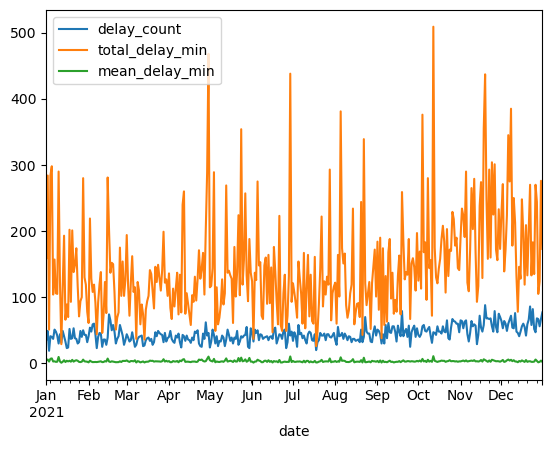

In [61]:
delay_summary.plot()

To create a separate plot for each column, we can specify `subplots=True`

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

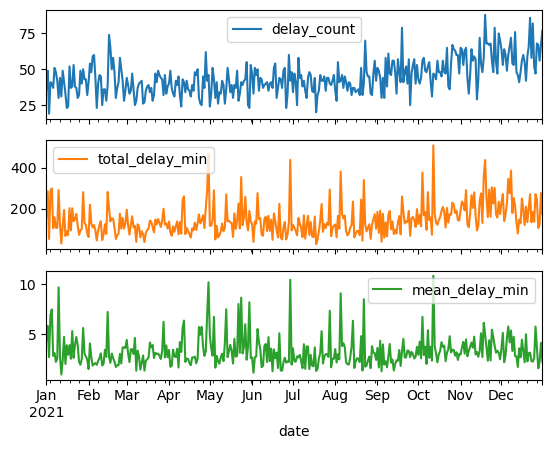

In [62]:
delay_summary.plot(subplots=True)

We can plot other aggregations too. Below, we use `line_groups` and calculate the size of each group, i.e., the number of delays reported on each line. Then we plot the data, telling `pandas` that the plot `kind` should be a bar graph, with TTC lines should in the `x`-axis. We also pass in a title.

<Axes: title={'center': 'Delays by Subway Line, 2021'}, xlabel='line'>

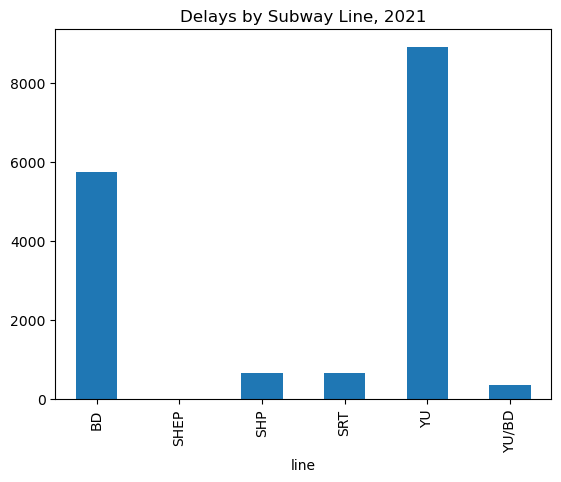

In [63]:
(line_groups
 .size()
 .plot(x='line',
       kind='bar',
       title='Delays by Subway Line, 2021'))

It is possible to sum up and plot the total delay time, in hours, by line.

<Axes: xlabel='line'>

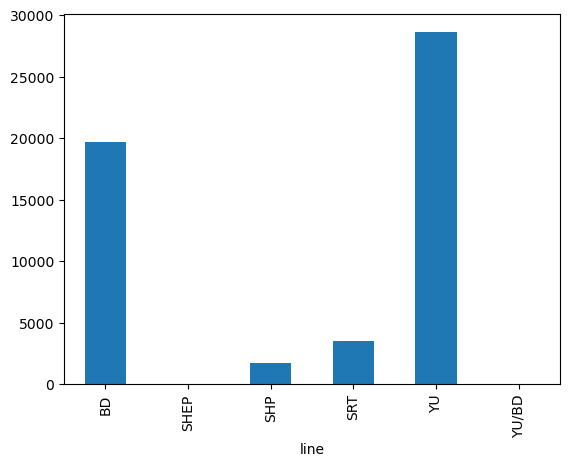

In [64]:
(delays_w_reasons
 .groupby('line')['min_delay']
 .sum()
 .plot(x='line', kind='bar'))

# Writing to file

## Exporting DataFrames

DataFrames have `to_[file format]()` methods, analagous to `pandas` read functions. The counterpart to `pd.read_csv()`, for instance, is `DataFrame.to_csv()`. The export methods generally take a file path to save to as their first argument. Additional arguments vary a bit by export format, but `index` is a common useful one. It takes a boolean of whether to write the index to file -- set it to `False` if the index is the numbered default.

Two additional useful parameters in `DataFrame.to_csv()` and `DataFrame.to_excel()` are `na_rep`, which takes a string to use for null values, and `columns`, which lets us write out a subset of columns.

In [65]:
# write delays_w_reasons to an Excel file
delays_w_reasons.to_excel('../data/ttc_subway_delays_w_reasons.xlsx', index=False)

# More wrangling

## Neighbourhood Profiles

The bike theft data includes neighbourhood identifiers. These neighbourhoods are designated by City of Toronto, which publishes neighbourhood demographic profiles. Let's get this data to start investigating if neighbourhoods with more bike theft reports simply have higher populations. In the process, we will reinforce what we learned so far. We will also learn about two last ways to reshape data: `melt()`, which rearranges data from a wide format to a long format; and `pivot()`, which reorganizes data based on index and column values.

## Getting data

Let's load the neighbourhood data and explore it.

In [66]:
profiles = pd.read_csv('../data/neighbourhood-profiles-2016-140-model.csv')

In [67]:
profiles.shape

(2383, 146)

The neighbourhood profiles are in an unusual format. Neighbourhood names are in the columns, while attribute fields are rows, and there are thousands of attributes.

In [68]:
profiles.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

Because of the layout and formatting characters, all of the numeric values have been read in as text data. It also looks like the characteristics are not unique.

In [69]:
profiles.dtypes.value_counts()

object    145
int64       1
Name: count, dtype: int64

In [70]:
len(profiles['Characteristic'].unique())

1651

## Removing extra whitespace

The characteristic values contain extra whitespace. Let's remove the whitespace up with `str.strip()`.

In [71]:
# the whitespace is easier to see in a list than a Series
list(profiles['Characteristic'][95:100])

['    Female parent',
 '    Male parent',
 'Couple census families in private households',
 '  Couples with children',
 '    1 child']

In [72]:
profiles['Characteristic'] = profiles['Characteristic'].str.strip()

# get the first 10 characteristics
list(profiles['Characteristic'][95:100])

['Female parent',
 'Male parent',
 'Couple census families in private households',
 'Couples with children',
 '1 child']

## Subsetting data

1651 characteristics is still a lot. Let's check out the categories to understand the areas covered.

In [73]:
profiles['Category'].unique()

array(['Neighbourhood Information', 'Population',
       'Families, households and marital status', 'Language', 'Income',
       'Immigration and citizenship', 'Visible minority', 'Ethnic origin',
       'Aboriginal peoples', 'Education', 'Housing', 'Language of work',
       'Labour', 'Journey to work', 'Mobility'], dtype=object)

"Journey to work" sounds relevant. We can use `.loc[]` to get the rows in that category, then select the Topic column and get its unique values.

In [74]:
profiles.loc[profiles['Category'] == 'Journey to work']['Topic'].unique()

array(['Commuting destination', 'Main mode of commuting',
       'Commuting duration', 'Time leaving for work'], dtype=object)

The "Population and dwellings" topic we saw in the DataFrame head looked promising as well. Let's check out the Characteristics in that topic.

In [75]:
profiles.loc[profiles['Topic'] == 'Population and dwellings']['Characteristic'].unique()

array(['Population, 2016', 'Population, 2011',
       'Population Change 2011-2016', 'Total private dwellings',
       'Private dwellings occupied by usual residents',
       'Population density per square kilometre',
       'Land area in square kilometres'], dtype=object)

Now that we know what topics we're interested in, let's create a subset DataFrame limited to them. We'll use the `copy()` DataFrame method to leave the original data untouched.

In [76]:
topics = ['Neighbourhood Information', 'Population and dwellings', 'Main mode of commuting']

# make sure it's an independent copy
profiles_subset = profiles.copy()

# get just the topics we're interested in
profiles_subset = profiles_subset.loc[profiles['Topic'].isin(topics)]
profiles_subset.shape

(16, 146)

## Reshaping data with `melt()`

Now we're ready to reshape our data. We can `drop()` the ID, data source, and category columns now.

To `melt()` a DataFrame, we specify `id_vars` -- the columns to keep as identifiers. All other columns are 'melted' into a new `variable` column. The values at DataFrame[id_vars, variable_col] move into a `value` column. We can change the names of the variable and value columns with the `var_name` and `value_name` arguments.

The `pandas` documentation provides an [illustrative example](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#reshaping-melt).

Let's `melt()` the profiles subset. We'll keep `Topic` and `Characteristic` as our `id_vars`. This will melt the neighbourhood names into the `variable` column, which we'll rename `Neighbourhood`.

In [77]:
profiles_subset.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

In [78]:
profiles_melt = (profiles_subset
                 .drop(columns=['_id', 'Data Source', 'Category'])
                 .melt(id_vars=['Topic', 'Characteristic'],
                       var_name='Neighbourhood'))

In [79]:
profiles_melt.head()

,Topic,Characteristic,Neighbourhood,value
0,Neighbourhood Information,Neighbourhood Number,City of Toronto,NaN
1,Neighbourhood Information,TSNS2020 Designation,City of Toronto,NaN
2,Population and dwellings,"Population, 2016",City of Toronto,"2,731,571"
3,Population and dwellings,"Population, 2011",City of Toronto,"2,615,060"
4,Population and dwellings,Population Change 2011-2016,City of Toronto,4.50%


In [80]:
profiles_melt = (profiles_subset
                 .drop(columns=['_id', 'Data Source', 'Category'])
                 .melt(id_vars=['Topic', 'Characteristic'],
                       var_name='Neighbourhood'))
profiles_melt.head()

,Topic,Characteristic,Neighbourhood,value
0,Neighbourhood Information,Neighbourhood Number,City of Toronto,NaN
1,Neighbourhood Information,TSNS2020 Designation,City of Toronto,NaN
2,Population and dwellings,"Population, 2016",City of Toronto,"2,731,571"
3,Population and dwellings,"Population, 2011",City of Toronto,"2,615,060"
4,Population and dwellings,Population Change 2011-2016,City of Toronto,4.50%


## Reshaping data with `pivot()`

The profile data is looking much closer to what we want! The next step is to make the Topic/Characteristic the column header, `pivot()`ing the values. To do this, we specify the column(s) to use as the `index`, or row labels; the column(s) whose values we should use as `column` names, and which column our `values` come from.

Pivoting on two columns creates a multi-level column header, so we then drop the top `Topic` level with `droplevel()`. Finally, we `reset_index()` to make neighbourhood names a regular column.

In [81]:
profiles_melt

,Topic,Characteristic,Neighbourhood,value
0,Neighbourhood Information,Neighbourhood Number,City of Toronto,NaN
1,Neighbourhood Information,TSNS2020 Designation,City of Toronto,NaN
2,Population and dwellings,"Population, 2016",City of Toronto,"2,731,571"
3,Population and dwellings,"Population, 2011",City of Toronto,"2,615,060"
4,Population and dwellings,Population Change 2011-2016,City of Toronto,4.50%
...,...,...,...,...
2251,Main mode of commuting,"Car, truck, van - as a passenger",Yorkdale-Glen Park,355
2252,Main mode of commuting,Public transit,Yorkdale-Glen Park,"2,400"
2253,Main mode of commuting,Walked,Yorkdale-Glen Park,360
2254,Main mode of commuting,Bicycle,Yorkdale-Glen Park,30


In [82]:
(profiles_melt.pivot(index='Neighbourhood',
                                      columns=['Topic', 'Characteristic'],
                                      values='value')).head()

Topic                        Neighbourhood Information                       \
Characteristic                    Neighbourhood Number TSNS2020 Designation   
Neighbourhood                                                                 
Agincourt North                                    129       No Designation   
Agincourt South-Malvern West                       128       No Designation   
Alderwood                                           20       No Designation   
Annex                                               95       No Designation   
Banbury-Don Mills                                   42       No Designation   

Topic                        Population and dwellings                   \
Characteristic                       Population, 2016 Population, 2011   
Neighbourhood                                                            
Agincourt North                                29,113           30,279   
Agincourt South-Malvern West                   23,757           21,988   
Alderwood                                      12,054           11,904   
Annex                                          30,526           29,177   
Banbury-Don Mills                              27,695           26,918   

Topic                                                     \
Characteristic               Population Change 2011-2016   
Neighbourhood                                              
Agincourt North                                   -3.90%   
Agincourt South-Malvern West                       8.00%   
Alderwood                                          1.30%   
Annex                                              4.60%   
Banbury-Don Mills                                  2.90%   

Topic                                                 \
Characteristic               Total private dwellings   
Neighbourhood                                          
Agincourt North                                9,371   
Agincourt South-Malvern West                   8,535   
Alderwood                                      4,732   
Annex                                         18,109   
Banbury-Don Mills                             12,473   

Topic                                                                       \
Characteristic               Private dwellings occupied by usual residents   
Neighbourhood                                                                
Agincourt North                                                      9,120   
Agincourt South-Malvern West                                         8,136   
Alderwood                                                            4,616   
Annex                                                               15,934   
Banbury-Don Mills                                                   12,124   

Topic                                                                 \
Characteristic               Population density per square kilometre   
Neighbourhood                                                          
Agincourt North                                                3,929   
Agincourt South-Malvern West                                   3,034   
Alderwood                                                      2,435   
Annex                                                         10,863   
Banbury-Don Mills                                              2,775   

Topic                                                        \
Characteristic               Land area in square kilometres   
Neighbourhood                                                 
Agincourt North                                        7.41   
Agincourt South-Malvern West                           7.83   
Alderwood                                              4.95   
Annex                                                  2.81   
Banbury-Don Mills                                      9.98   

Topic                                                                                                                                    

In [83]:
neighbourhoods = (profiles_melt.pivot(index='Neighbourhood',
                                      columns=['Topic', 'Characteristic'],
                                      values='value')
                               .droplevel(0, axis=1) # remove topic col header
                               .reset_index()) # make Neighbourhood a regular column
neighbourhoods.head()

Characteristic,Neighbourhood,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,Total - Main mode of commuting for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data,"Car, truck, van - as a driver","Car, truck, van - as a passenger",Public transit,Walked,Bicycle,Other method
0,Agincourt North,129,No Designation,"29,113","30,279",-3.90%,"9,371","9,120","3,929",7.41,"11,820","7,155",930,"3,350",265,70,45
1,Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,"10,160","6,135",665,"2,985",280,35,65
2,Alderwood,20,No Designation,"12,054","11,904",1.30%,"4,732","4,616","2,435",4.95,"6,045","4,090",355,"1,285",195,65,65
3,Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,"14,910","3,290",290,"6,200","3,200","1,675",225
4,Banbury-Don Mills,42,No Designation,"27,695","26,918",2.90%,"12,473","12,124","2,775",9.98,"11,395","7,150",500,"2,945",615,65,140


## Renaming all columns

Much better! These column names could be shorter, though. Let's rename them to be easier to work with. We could use the `rename()` DataFrame method, passing in a dictionary of old and new names. Since there isn't an easy renaming function, and some of the current names are very long, we will instead reassign a list of new names to the `columns` attribute of our DataFrame.

In [84]:
# rename all columns
neighbourhoods.columns = ['neighbourhood',
                          'n_id',
                          'designation',
                          'pop_2016',
                          'pop_2011',
                          'pop_change',
                          'private_dwellings',
                          'occupied_dwllings',
                          'pop_dens',
                          'area',
                          'total_commuters',
                          'drive',
                          'car_passenger',
                          'transit',
                          'walk',
                          'bike',
                          'other']
neighbourhoods.columns

Index(['neighbourhood', 'n_id', 'designation', 'pop_2016', 'pop_2011',
       'pop_change', 'private_dwellings', 'occupied_dwllings', 'pop_dens',
       'area', 'total_commuters', 'drive', 'car_passenger', 'transit', 'walk',
       'bike', 'other'],
      dtype='object')

## Replacing values in multiple columns

All of the values in our neighbourhood data are text right now. Part of the problem is that numbers contain characters like commas and percentage signs. We can remove these from everywhere in our data with the DataFrame `replace()` method, which takes a string to look for and a replacement string. Normally, `replace()` looks for a perfect, full-string match. Since we're only looking for a substring match, we set `regex=True`.

In [85]:
# for those comfortable with regex, ',|%' and '[,%]' also work
neighbourhoods = (neighbourhoods.replace(',', '', regex=True)
                                .replace('%', '', regex=True)) # whether to interpret as regular expressions
neighbourhoods.head(2)

,neighbourhood,n_id,designation,pop_2016,pop_2011,pop_change,private_dwellings,occupied_dwllings,pop_dens,area,total_commuters,drive,car_passenger,transit,walk,bike,other
0,Agincourt North,129,No Designation,29113,30279,-3.90,9371,9120,3929,7.41,11820,7155,930,3350,265,70,45
1,Agincourt South-Malvern West,128,No Designation,23757,21988,8.00,8535,8136,3034,7.83,10160,6135,665,2985,280,35,65


## `apply()`ing a function to multiple columns

Now the numbers look like numbers, but they are still strings. We can convert them with `pd.to_numeric()`, which takes a Series and returns it as the most appropriate numeric data type. Doing this for columns one-by-one would be tedious. Instead, we can use the `apply()` DataFrame method to run a function on every column in a DataFrame. `apply()` takes the name of the function to apply and any arguments needed to run that function. We only want to convert from `pop_2016` onwards, so we'll use `.loc[]` to select the correct columns.

In [86]:
# select all rows, columns from pop_2016 to end
neighbourhoods.loc[:, 'pop_2016':] = neighbourhoods.loc[:, 'pop_2016':].apply(pd.to_numeric)
neighbourhoods.head()

,neighbourhood,n_id,designation,pop_2016,pop_2011,pop_change,private_dwellings,occupied_dwllings,pop_dens,area,total_commuters,drive,car_passenger,transit,walk,bike,other
0,Agincourt North,129,No Designation,29113,30279,-3.9,9371,9120,3929,7.41,11820,7155,930,3350,265,70,45
1,Agincourt South-Malvern West,128,No Designation,23757,21988,8.0,8535,8136,3034,7.83,10160,6135,665,2985,280,35,65
2,Alderwood,20,No Designation,12054,11904,1.3,4732,4616,2435,4.95,6045,4090,355,1285,195,65,65
3,Annex,95,No Designation,30526,29177,4.6,18109,15934,10863,2.81,14910,3290,290,6200,3200,1675,225
4,Banbury-Don Mills,42,No Designation,27695,26918,2.9,12473,12124,2775,9.98,11395,7150,500,2945,615,65,140


## Calculating more columns

Let's fix the population change column and calculate the percentage of commuters who bike.

In [87]:
neighbourhoods['pop_change'] = neighbourhoods['pop_change'] / 100
neighbourhoods['pct_bike'] = neighbourhoods['bike'] / neighbourhoods['total_commuters']
neighbourhoods.head()

,neighbourhood,n_id,designation,pop_2016,pop_2011,pop_change,private_dwellings,occupied_dwllings,pop_dens,area,total_commuters,drive,car_passenger,transit,walk,bike,other,pct_bike
0,Agincourt North,129,No Designation,29113,30279,-0.039,9371,9120,3929,7.41,11820,7155,930,3350,265,70,45,0.005922
1,Agincourt South-Malvern West,128,No Designation,23757,21988,0.08,8535,8136,3034,7.83,10160,6135,665,2985,280,35,65,0.003445
2,Alderwood,20,No Designation,12054,11904,0.013,4732,4616,2435,4.95,6045,4090,355,1285,195,65,65,0.010753
3,Annex,95,No Designation,30526,29177,0.046,18109,15934,10863,2.81,14910,3290,290,6200,3200,1675,225,0.112341
4,Banbury-Don Mills,42,No Designation,27695,26918,0.029,12473,12124,2775,9.98,11395,7150,500,2945,615,65,140,0.005704


## `merge()`ing

The profile are now ready to merge into the bike thefts data!

In [88]:
thefts_demo = pd.merge(thefts,
                       neighbourhoods,
                       how='left',
                       left_on='hood_id',
                       right_on='n_id')
thefts_demo.head()

,_id,objectid,event_unique_id,primary_offence,occurrence_date,occurrence_year,occurrence_month,occurrence_dayofweek,occurrence_dayofmonth,occurrence_dayofyear,occurrence_hour,report_date,report_year,report_month,report_dayofweek,report_dayofmonth,report_dayofyear,report_hour,division,city,hood_id,neighbourhoodname,location_type,premises_type,bike_make,bike_model,bike_type,bike_speed,bike_colour,bike_cost,status,objectid2,geometry,neighbourhood,n_id,designation,pop_2016,pop_2011,pop_change,private_dwellings,occupied_dwllings,pop_dens,area,total_commuters,drive,car_passenger,transit,walk,bike,other,pct_bike
0,1,17744,GO-20179016397,THEFT UNDER,2017-10-03,2017,October,Tuesday,3,276,14,2017-10-03,2017,October,Tuesday,3,276,18,D22,Toronto,15,Kingsway South (15),"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,GI,ESCAPE 2,OT,7,BLK,700.0,STOLEN,1,"{'type': 'Point', 'coordinates': (-79.50655965...",Kingsway South,15,No Designation,9271,9170,0.011,3710,3584,3593,2.58,3735,2210,120,1185,115,30,50,0.008032
1,2,17759,GO-20172033056,THEFT UNDER - BICYCLE,2017-11-08,2017,November,Wednesday,8,312,3,2017-11-08,2017,November,Wednesday,8,312,22,D22,Toronto,15,Kingsway South (15),"Single Home, House (Attach Garage, Cottage, Mo...",House,UNKNOWN MAKE,NaN,TO,1,BLK,1100.0,RECOVERED,2,"{'type': 'Point', 'coordinates': (-79.50484874...",Kingsway South,15,No Designation,9271,9170,0.011,3710,3584,3593,2.58,3735,2210,120,1185,115,30,50,0.008032
2,3,17906,GO-20189030822,THEFT UNDER - BICYCLE,2018-09-14,2018,September,Friday,14,257,9,2018-09-17,2018,September,Monday,17,260,16,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,OT,CROSSTRAIL,MT,24,BLK,904.0,STOLEN,3,"{'type': 'Point', 'coordinates': (-79.51170915...",Kingsway South,15,No Designation,9271,9170,0.011,3710,3584,3593,2.58,3735,2210,120,1185,115,30,50,0.008032
3,4,17962,GO-2015804467,THEFT UNDER,2015-05-07,2015,May,Thursday,7,127,18,2015-05-14,2015,May,Thursday,14,134,14,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,GT,NaN,TO,10,BLKDGR,400.0,STOLEN,4,"{'type': 'Point', 'coordinates': (-79.51170915...",Kingsway South,15,No Designation,9271,9170,0.011,3710,3584,3593,2.58,3735,2210,120,1185,115,30,50,0.008032
4,5,17963,GO-20159002781,THEFT UNDER,2015-05-16,2015,May,Saturday,16,136,12,2015-05-16,2015,May,Saturday,16,136,15,D22,Toronto,15,Kingsway South (15),Ttc Subway Station,Transit,GI,NaN,MT,6,RED,600.0,STOLEN,5,"{'type': 'Point', 'coordinates': (-79.51132657...",Kingsway South,15,No Designation,9271,9170,0.011,3710,3584,3593,2.58,3735,2210,120,1185,115,30,50,0.008032


## Grouping and plotting

With the datasets joned, we can aggregate and plot the data. We can start using statistical methods, like `corr()` to check for relationships between variables as well.

In [89]:
thefts_2016_grouped = (thefts_demo
                       .query('occurrence_year == 2016')
                       .groupby(['neighbourhood']))

<Axes: ylabel='Frequency'>

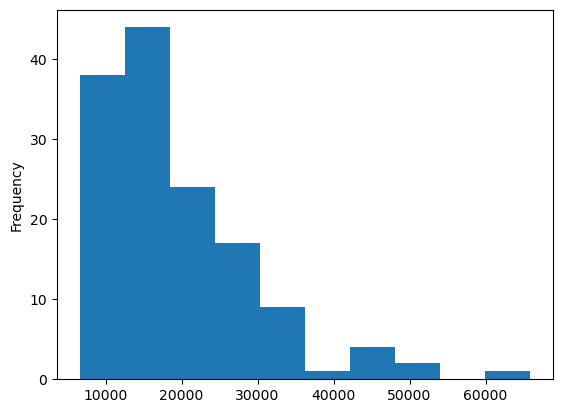

In [90]:
# neighbourhood populations are skewed
neighbourhoods.query('neighbourhood != "City of Toronto"')['pop_2016'].plot(kind='hist')

<Axes: ylabel='Frequency'>

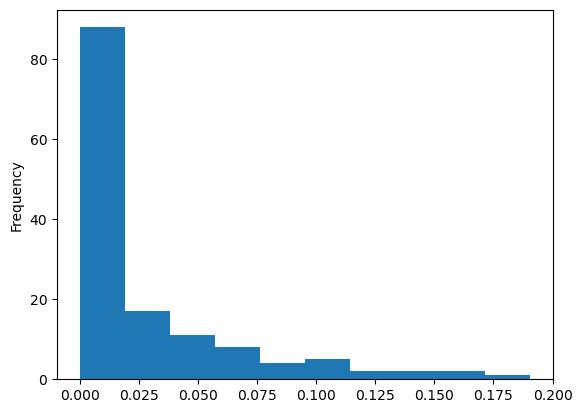

In [91]:
# so are the % of commuters who bike to work
neighbourhoods.query('neighbourhood != "City of Toronto"')['pct_bike'].plot(kind='hist')

<Axes: ylabel='Frequency'>

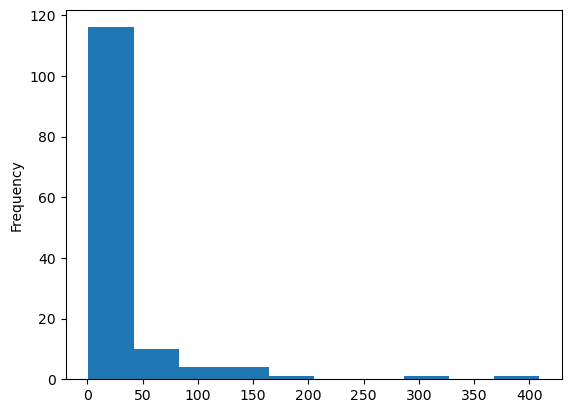

In [92]:
# as are thefts
thefts_2016_grouped.size().plot(kind='hist')

In [93]:
(thefts_2016_grouped
 .agg(total_thefts=('_id', 'count'),
      pop=('pop_2016', 'median'),
      pct_bike=('pct_bike', 'mean'))).head()

,total_thefts,pop,pct_bike
neighbourhood,,,
Agincourt North,2,29113.0,0.005922
Agincourt South-Malvern West,3,23757.0,0.003445
Alderwood,3,12054.0,0.010753
Annex,130,30526.0,0.112341
Banbury-Don Mills,4,27695.0,0.005704


<Axes: xlabel='pop', ylabel='total_thefts'>

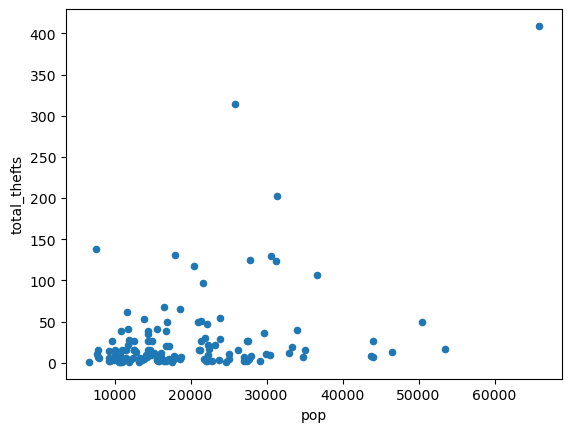

In [94]:
# thefts counts vs population
(thefts_2016_grouped
 .agg(total_thefts=('_id', 'count'),
      pop=('pop_2016', 'median'),
      pct_bike=('pct_bike', 'mean'))
 .reset_index()
 .plot(kind='scatter', y='total_thefts', x='pop'))

<Axes: title={'center': 'Reported Bike Thefts, 2016'}, xlabel='neighbourhood'>

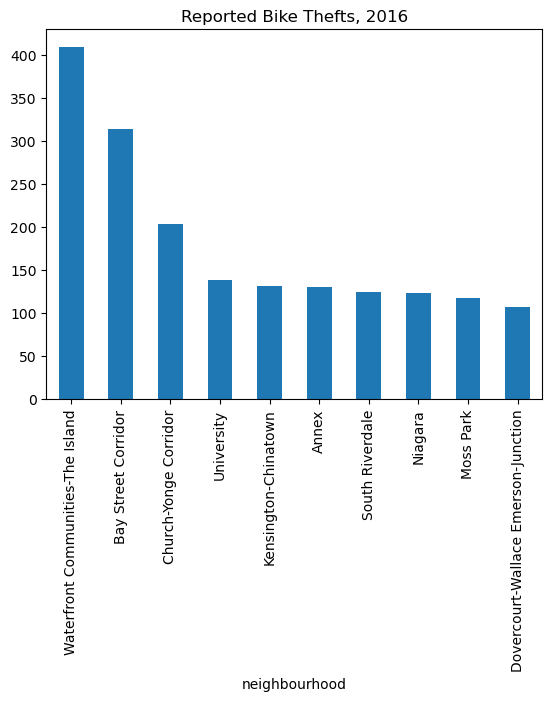

In [95]:
(thefts_2016_grouped
 .size()
 .sort_values(ascending=False)
 .head(10)
 .plot(kind='bar', title='Reported Bike Thefts, 2016'))

In [96]:
# a quick correlation check
(thefts_2016_grouped
 .agg(total_thefts=('_id', 'count'),
      pop=('pop_2016', 'median'),
      dens=('pop_dens', 'median'),
      pct_bike=('pct_bike', 'mean'))
 .corr('spearman'))

,total_thefts,pop,dens,pct_bike
total_thefts,1.000000,0.267761,0.485556,0.651319
pop,0.267761,1.000000,0.020082,-0.222565
dens,0.485556,0.020082,1.000000,0.605242
pct_bike,0.651319,-0.222565,0.605242,1.000000


In [97]:
thefts_demo.to_csv('../data/bike_thefts_joined.csv', index=False)
neighbourhoods.to_csv('../data/neighbourhoods.csv', index=False)

# References

### Programming
- pandas development team. _API reference_. https://pandas.pydata.org/pandas-docs/stable/reference/index.html
- pandas development team. _User guide_. https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html
- _Python strftime cheatsheet_. https://strftime.org/


### Data Sources
- Open Data Toronto. _Neighbourhood Profiles_. https://open.toronto.ca/dataset/neighbourhood-profiles/
- Open Data Toronto. _TTC Subway Delay Data_. https://open.toronto.ca/dataset/ttc-subway-delay-data/
- Open Data Toronto. _Bicyle Thefts_. https://open.toronto.ca/dataset/bicycle-thefts/